In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np

This notebook goes through an example of a general technique for converting a non-spiking neuron model into a spiking neuron model.  This technique is from https://arxiv.org/abs/2002.03553

We start with a particular neuron model we want to convert.  This could be anything at all, but here we're going to use a leaky integrator model defined like this:

In [2]:
class LeakyIntegrator:
    def __init__(self, threshold, tau_rc=20):
        self.threshold = threshold
        self.tau_rc = tau_rc
        self.v = 0
        
    def step(self, J):
        if self.v > self.threshold:
            output = self.v - self.threshold
        else:
            output = 0
            
        dv = -self.v + output + J
        self.v += dv / self.tau_rc
        return output    

Now let's run the model with some random input just to get some basic behaviour out of the model

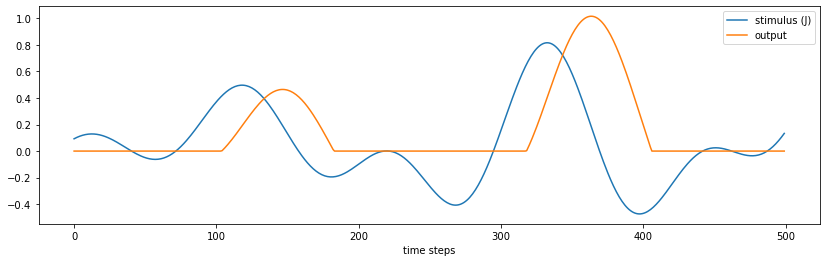

In [3]:
steps = 500
# use Nengo to generate a random input signal
stim = nengo.processes.WhiteSignal(high=10, period=2, rms=0.3, seed=2).run_steps(steps, dt=0.001)


# make a neuron
neuron = LeakyIntegrator(threshold=0.2, tau_rc=20)

# run the simulation
output_nonspiking = np.zeros(steps)
for i in range(steps):
    output_nonspiking[i] = neuron.step(stim[i])

plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output')
plt.xlabel('time steps')
plt.legend()
plt.show()

So that's the basic behaviour we want to emulate with a spiking neuron.  The general approach is just to round the output!  We take whatever the neuron model is doing already, but we take the output and add it into an accumulator.  Then we check if the accumulator is above 1.  If it is, we emit a spike and subtract 1 from the accumulator.  If it isn't we don't emit a spike.  Here's the result:

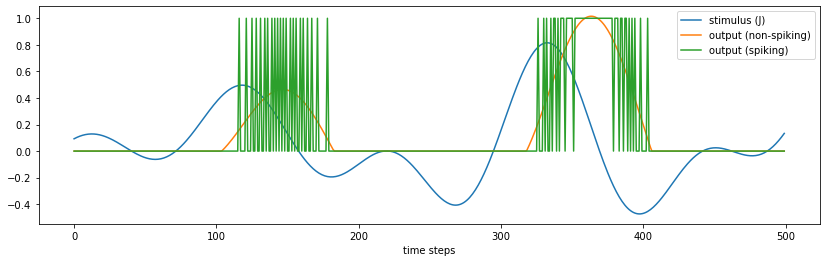

In [4]:
class LeakyIntegratorSpiking:
    def __init__(self, threshold, tau_rc=20):
        self.threshold = threshold
        self.tau_rc = tau_rc
        self.v = 0
        self.output_accumulator = 0
        
    def step(self, J):
        if self.v > self.threshold:
            output = self.v - self.threshold
        else:
            output = 0
            
        dv = -self.v + output + J
        self.v += dv / self.tau_rc
        
        self.output_accumulator += output
        output = int(self.output_accumulator)
        self.output_accumulator -= output
        
        return output
    
output = np.zeros(steps)
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.show()

So there's a spiking neuron!  It only outputs 0s and 1s, and it approximates the behaviour of the non-spiking neuron.  

However, there is something a bit odd there.  During that output peak around time step 380, the neuron is spiking every time step.  It would be nice to introduce a parameter that would let us control that.  Right now, if the non-spiking output is a 1, that corresponds to 1 spike every time-step.  So, to control this, let's introduce a parameter that we'll call `spike_height`.  This tells us what effective value does one spike correspond to.  So then we could do something like set `spike_height=2`, and that would mean that at an output value of 2 it'd spike every time-step, but at an output value of 1 it'd spike every other time step:

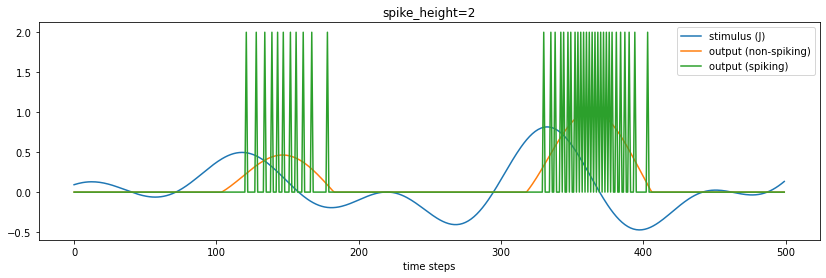

In [5]:
class LeakyIntegratorSpiking:
    def __init__(self, threshold, tau_rc=20, spike_height=1.0):
        self.threshold = threshold
        self.tau_rc = tau_rc
        self.v = 0
        self.output_accumulator = 0
        self.spike_height = spike_height
        
    def step(self, J):
        if self.v > self.threshold:
            output = self.v - self.threshold
        else:
            output = 0
            
        dv = -self.v + output + J
        self.v += dv / self.tau_rc
        
        self.output_accumulator += output / self.spike_height
        output = int(self.output_accumulator)
        self.output_accumulator -= output
        
        return output * self.spike_height
    
output = np.zeros(steps)
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=2)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

We could even slow the spiking down even farther:

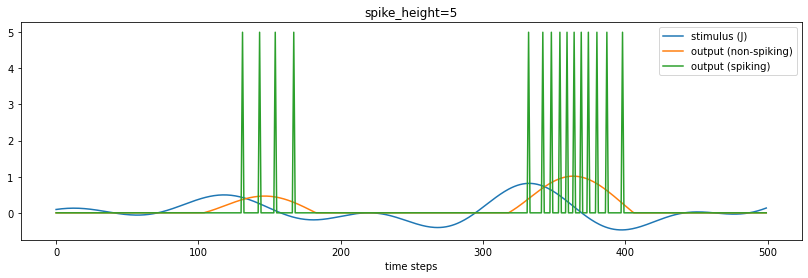

In [6]:
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=5)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

So that's a nice simple way of making any neuron spiking.

But, there's also one other *very* cool side effect of this approach.  What if I start *decreasing* `spike_height`?

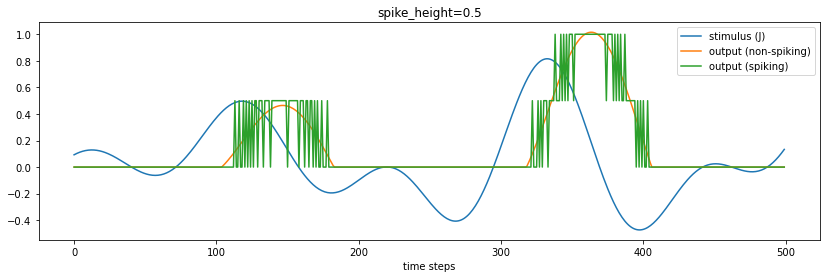

In [7]:
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=0.5)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

Yikes!  What happened there?  Now when the peak happens, it's actually emitting 2 spikes per time step!  This is because the accumulator has a value in it that is twice the threshold, and they way I implemented the threshold detection to emit a spike was just like this:

```
        self.output_accumulator += output / self.spike_height
        output = int(self.output_accumulator)
        self.output_accumulator -= output
```

That casting to an integer is a nice shortcut, and if our values are small enough, then `output` will only ever be 0 or 1.  But, if the output is supposed to be large enough that we should output 2 spikes on this same timestep, then this algorithm will go ahead and do so.

(Interestingly, if you do this trick to a neuron that can output negative numbers, then this algorithm will also go ahead and produce negative spikes!)

So what happens if we reduce this value even further?

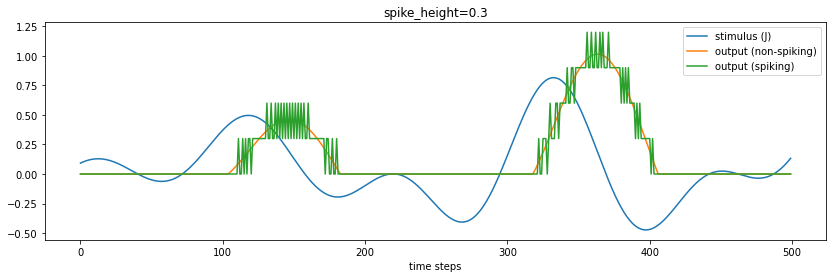

In [8]:
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=0.3)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

And further?

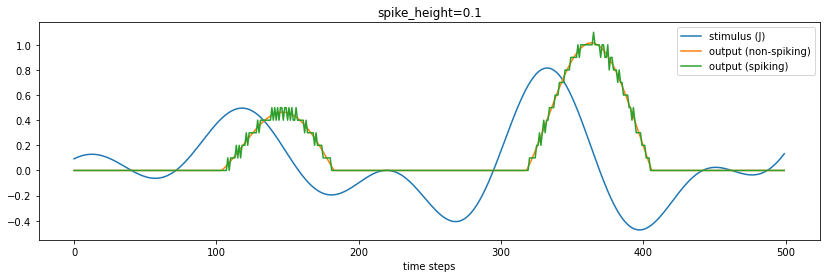

In [9]:
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=0.1)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

And even further?

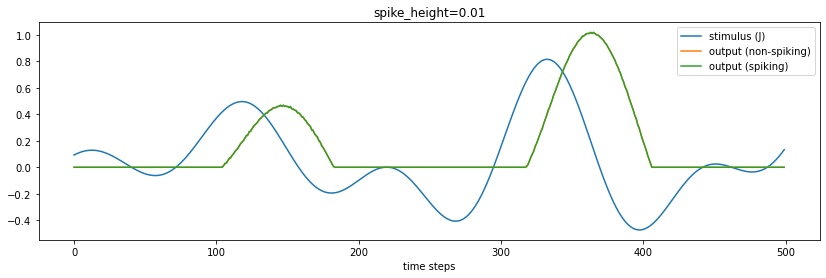

In [10]:
neuron = LeakyIntegratorSpiking(threshold=0.2, tau_rc=20, spike_height=0.01)

for i in range(steps):
    output[i] = neuron.step(stim[i])
    
plt.figure(figsize=(14,4))
plt.plot(stim, label='stimulus (J)')
plt.plot(output_nonspiking, label='output (non-spiking)')
plt.plot(output, label='output (spiking)')
plt.xlabel('time steps')
plt.legend()
plt.title(f'spike_height={neuron.spike_height}')
plt.show()

If we reduce the `spike_height` far enough, we get back our original non-spiking neuron model!  

What's happening here is that the `spike_height` parameter is letting us control the level of descritization that we are using.  In the paper where this was introduced (https://arxiv.org/abs/2002.03553), this was used to help do backprop training on spiking neural networks.  You can start the training on the non-spiking version, and then gradually increase the `spike_height` parameter ($1/\omega$ in the paper) over time as training occurs.

Interestingly, you can also think of multiple-spikes-per-timestep as a single spike, but with a magnitude.  Some neuromorphic chips do support this, including SpiNNaker and Loihi 2:  https://www.embedded.com/intel-offers-loihi-2-neuromorphic-chip-and-software-framework/ ("In Loihi 2, spikes carry a configurable integer payload available to the programmable neuron model.")

# Nengo and NengoOpenCL version

In [72]:
import nengo_ocl

class LeakyIntegrator(nengo.LIF):
    threshold = nengo.params.NumberParam('threshold')
    
    def __init__(self, threshold=0, tau_rc=0.02, spike_height=1):
        super().__init__(tau_rc=tau_rc, tau_ref=0)
        self.threshold = threshold
        self.spike_height = spike_height
        
    def step(self, dt, J, output, voltage, refractory_time):
        accumulator = refractory_time
        # to map to the paper: output is y, voltage is u, and J is the inputs times the dictionary matrix
        
        # y = T(u)
        output[:] = np.where(voltage>self.threshold, voltage-self.threshold, 0)
        
        # du/dt = -u + y + phi*r
        dv = -voltage + output + J
        
        # perform the voltage update
        voltage += dv*(dt/self.tau_rc)
        
        accumulator += output / self.spike_height
        output[:] = np.fix(accumulator)
        accumulator -= output
        output *= self.spike_height
        

from nengo_ocl.utils import as_ascii
from mako.template import Template   
from nengo_ocl.clra_nonlinearities import _plan_template
def plan_leaky_integrator(queue, dt, J, V, outR, thresh, inv_tau, acc, spike_height, **kwargs):
    assert J.ctype == 'float'
    for x in [V, outR]:
        assert x.ctype == J.ctype

    inputs = dict(J=J, V=V, acc=acc)
    outputs = dict(outV=V, outAcc=acc, outR=outR)
    parameters = dict(inv_tau=inv_tau, thresh=thresh, spike_height=spike_height)
    textconf = dict(type=J.ctype, dt=dt)

    decs = """
        const ${type} dt = ${dt};
        ${type} n_spikes;
        """
    text = """
        if (V>thresh) {
            acc += (V-thresh) / spike_height;
            n_spikes = floor(acc);
            acc -= n_spikes;
            V += (-thresh+J)*(dt * inv_tau);
            outR = n_spikes * spike_height;
        } else {
            V += (-V+J)*(dt * inv_tau);
            outR = 0;
        }
        outV = V;
        outAcc = acc;
        """
    decs = as_ascii(Template(decs, output_encoding='ascii').render(**textconf))
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))
    cl_name = "cl_leaky_integrator"
    return _plan_template(
        queue, cl_name, text, declares=decs,
        inputs=inputs, outputs=outputs, parameters=parameters, **kwargs)    


class OpenCLSimulator(nengo_ocl.Simulator):
    def _plan_LeakyIntegrator(self, ops):
        dt = self.model.dt
        J = self.all_data[[self.sidx[op.J] for op in ops]]
        V = self.all_data[[self.sidx[op.state["voltage"]] for op in ops]]
        R = self.all_data[[self.sidx[op.output] for op in ops]]
        thresh = self.RaggedArray([op.neurons.threshold * np.ones(op.J.size)
                                   for op in ops], dtype=J.dtype)
        inv_tau = self.RaggedArray([(1/op.neurons.tau_rc) * np.ones(op.J.size)
                                for op in ops], dtype=J.dtype)
        acc = self.RaggedArray([np.zeros(op.J.size)
                                for op in ops], dtype=J.dtype)
        sh =  self.RaggedArray([op.neurons.spike_height * np.ones(op.J.size)
                                   for op in ops], dtype=J.dtype)
        return [plan_leaky_integrator(self.queue, dt, J, V, R, thresh, inv_tau, acc, sh)]
        
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(high=10, period=2, rms=0.3, seed=2))
    ens = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=nengo.dists.Choice([[1]]), gain=nengo.dists.Choice([1]), bias=nengo.dists.Choice([0]),
                         neuron_type=LeakyIntegrator(tau_rc=0.02, spike_height=0.1, threshold=0.2))
    nengo.Connection(stim, ens.neurons, transform=np.ones((ens.n_neurons, 1)))
    
    p = nengo.Probe(ens.neurons)


#sim = OpenCLSimulator(model)
sim = nengo.Simulator(model)
with sim:
    sim.run(0.5)


c:\users\terry\git\nengo\nengo\neurons.py:578: RuntimeWarning: divide by zero encountered in log1p
  self.tau_ref - self.tau_rc * np.log1p(1.0 / (gain * (intercepts - 1) - 1))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

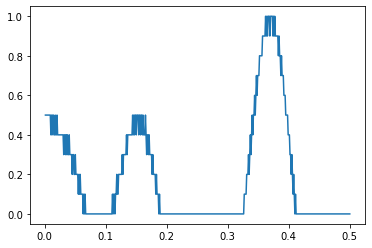

In [73]:
plt.plot(sim.trange(), sim.data[p][:,0])

In [87]:
class SpikingLinear(nengo.RectifiedLinear):
    state = {"accumulator": nengo.dists.Uniform(low=0, high=1)}
    spiking = True    
    spike_height = nengo.params.NumberParam('spike_height')
    
    def __init__(self, spike_height=1):
        super().__init__()
        self.spike_height = spike_height
    
    def step(self, dt, J, output, accumulator):
        accumulator += J / self.spike_height
        output[:] = np.fix(accumulator)
        accumulator -= output
        output *= self.spike_height
        

from nengo_ocl.utils import as_ascii
from mako.template import Template   
from nengo_ocl.clra_nonlinearities import _plan_template
def plan_spiking_linear(queue, dt, J, outR, acc, spike_height, **kwargs):
    assert J.ctype == 'float'
    for x in [outR]:
        assert x.ctype == J.ctype

    inputs = dict(J=J, acc=acc)
    outputs = dict(outAcc=acc, outR=outR)
    parameters = dict(spike_height=spike_height)
    textconf = dict(type=J.ctype, dt=dt)

    decs = """
        const ${type} dt = ${dt};
        ${type} n_spikes;
        """
    text = """
        acc += J / spike_height;
        n_spikes = trunc(acc);
        acc -= n_spikes;
        outR = n_spikes * spike_height;
        outAcc = acc;
        """
    decs = as_ascii(Template(decs, output_encoding='ascii').render(**textconf))
    text = as_ascii(Template(text, output_encoding='ascii').render(**textconf))
    cl_name = "cl_spiking_linear"
    return _plan_template(
        queue, cl_name, text, declares=decs,
        inputs=inputs, outputs=outputs, parameters=parameters, **kwargs)    


class OpenCLSimulator(nengo_ocl.Simulator):
    def _plan_SpikingLinear(self, ops):
        dt = self.model.dt
        J = self.all_data[[self.sidx[op.J] for op in ops]]
        acc = self.all_data[[self.sidx[op.state["accumulator"]] for op in ops]]
        R = self.all_data[[self.sidx[op.output] for op in ops]]
        sh =  self.RaggedArray([op.neurons.spike_height * np.ones(op.J.size)
                                   for op in ops], dtype=J.dtype)
        return [plan_spiking_linear(self.queue, dt, J, R, acc, sh)]
        
model = nengo.Network()
with model:
    stim = nengo.Node(nengo.processes.WhiteSignal(high=10, period=2, rms=0.3, seed=2))
    ens = nengo.Ensemble(n_neurons=1, dimensions=1, encoders=nengo.dists.Choice([[1]]), gain=nengo.dists.Choice([1]), bias=nengo.dists.Choice([0]),
                         neuron_type=SpikingLinear(spike_height=0.1))
    nengo.Connection(stim, ens.neurons, transform=np.ones((ens.n_neurons, 1)))
    
    p = nengo.Probe(ens.neurons)


sim = OpenCLSimulator(model)
#sim = nengo.Simulator(model)
with sim:
    sim.run(0.5)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

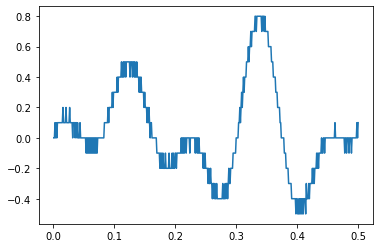

In [88]:
plt.plot(sim.trange(), sim.data[p])